In [13]:

from __future__ import division

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches

%matplotlib inline

#dataset
#our data will be a collection of ranodm colors so first we will 
#artificially create a dataset of 100.
#Each color si a 3D vector representing R, G, B values

raw_data = np.random.randint(0, 255,(3, 100))

#our objective is to take our 3D color vectors and map them into 2D
#surface in such way that similar colors will end up in the same area of the 2D surface

network_dimensions =np.array([5, 5])
n_iterations = 10000
init_learning_rate = 0.01
#establish size variables based on data

m = raw_data.shape[0]
n = raw_data.shape[1]
# weight matrix (i.e. the SOM) needs to be one m-dimensional vector for each neuron in the SOM
net = np.random.random((network_dimensions[0], network_dimensions[1], m))  

#initial neighbourhood radius
init_radius = max(network_dimensions[0], network_dimensions[1]) / 2
#radius decay parameter
time_constant = n_iterations / np.log(init_radius)


In [14]:
#first of all, SOMs train faster and better if all our values are between 0 and 1
#in our case all 3 dimensions refer to a value between 0 and 255 so we can normalise the entire dataset at once

normalise_data = True

#if True, assume all data si on common scale
#if False, normalise to [0 1] range along each column

normalise_by_column = False

#we keep a copy of the raw_data for later
data = raw_data

#check if data needs to be normalised
if normalise_data:
    if normalise_by_column:
        #normalise along each column
        col_maxes = raw_data.max(axis=0)
        data = raw_data / col_maxes[np.newaxis, :]
    else:
        #normalise entire dataset
        data = raw_data / data.max()

In [15]:
#learning process will be as follows.
#for a single iteration:
    #1. Find the neuron in the SOM whose associated 3D vector is 
     #closest to our chosen 3D color vector. At each step, this is called the best Matching Unit(BMU)
    #2. Move the BMU's 3D weight vector closer to the input vector in 3D space
    #3. Identify the 2D neighbours of the BMU and also move their 3D
        #weight vectors closer to the input vector, although by a smaller amount
    #4.Update the learning rate

#for that to work we need a function to find the BMU. it need to 
#through each neuron in the SOM, measure its Euclidean distance to 
#our input vector and return the one that's closest.

def find_bmu(t, net, m):
    """
        Find the best matching unit for a given vector, t, in the SOM
        Returns :  a (bmu, bmu_idx) tuple where bmu is the high-dimensional BMU
        and bmu_idx is the index of this vector in the SOM
    """
    bmu_idx = np.array([0, 0])
    #set the initial minimum distance to a huge number
    min_dist = np.iinfo(np.int).max
    # calculate the high-dimensional distance between each neuron and the input
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            #don't bother with actual Euclidean distance, to avoid expensive sqrt operation
            sq_dist = np.sum((w - t)**2)
            if sq_dist < min_dist:
                min_dist = sq_dist
                bmu_idx = np.array([x, y])
    #get vector corresponding to bmu_idx
    bmu = net[bmu_idx[0], bmu_idx[1], :].reshape(m, 1)
    #return the (bmu, bmu_idx) tuple
    return (bmu, bmu_idx)

In [16]:
# Decay the SOM parameters
# The function to decay the radius and learning rate use exponential decay
def decay_radius(initial_radius, i, time_constant):
    return initial_radius * np.exp(-i / time_constant)
def decay_learning_rate(initial_learning_rate, i, n_iterations):
    return initial_learning_rate * np.exp(-i / n_iterations)

In [17]:
def calculate_influence(distance, radius):
    return np.exp(-distance / (2 * (radius**2)))

for i in range(n_iterations):
    #print('Iteration %d' % i)
    
    # select a training example at random
    t = data[:, np.random.randint(0, n)].reshape(np.array([m, 1]))
    
    # find its Best Matching Unit
    bmu, bmu_idx = find_bmu(t, net, m)
    
    # decay the SOM parameters
    r = decay_radius(init_radius, i, time_constant)
    l = decay_learning_rate(init_learning_rate, i, n_iterations)
    
    # now we know the BMU, update its weight vector to move closer to input
    # and move its neighbours in 2-D space closer
    # by a factor proportional to their 2-D distance from the BMU
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            # get the 2-D distance (again, not the actual Euclidean distance)
            w_dist = np.sum((np.array([x, y]) - bmu_idx) ** 2)
            # if the distance is within the current neighbourhood radius
            if w_dist <= r**2:
                # calculate the degree of influence (based on the 2-D distance)
                influence = calculate_influence(w_dist, r)
                # now update the neuron's weight using the formula:
                # new w = old w + (learning rate * influence * delta)
                # where delta = input vector (t) - old w
                new_w = w + (l * influence * (t - w))
                # commit the new weight
                net[x, y, :] = new_w.reshape(1, 3)

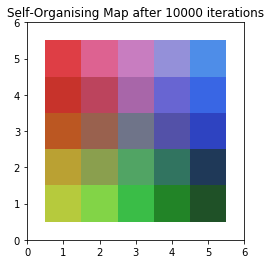

In [18]:
#plot the colour map
fig = plt.figure()
# setup axes
ax = fig.add_subplot(111, aspect='equal')
ax.set_xlim((0, net.shape[0]+1))
ax.set_ylim((0, net.shape[1]+1))
ax.set_title('Self-Organising Map after %d iterations' % n_iterations)

# plot the rectangles
for x in range(1, net.shape[0] + 1):
    for y in range(1, net.shape[1] + 1):
        ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                     facecolor=net[x-1,y-1,:],
                     edgecolor='none'))
plt.show()
